# Construir un modelo de clasificación para detectar pacientes con riesgo de vida a partir del conjunto de datos "Derecho de solicitud" en el sistema de salud colombiano

The downloaded datasets should be placed in subfolder "datasets/". It's posible to downloads the datasets directly from:

- https://www.datos.gov.co/api/views/36n3-fsjh/rows.csv?accessType=DOWNLOAD
- https://www.datos.gov.co/api/views/b3xk-8uh2/rows.csv?accessType=DOWNLOAD
- https://www.datos.gov.co/api/views/gg2r-kx6x/rows.csv?accessType=DOWNLOAD

Dictionary of columns
-  https://dev.socrata.com/foundry/www.datos.gov.co/b3xk-8uh2

### SUPERSALUD - MISIÓN :
    Proteger los derechos de los usuarios de salud a través de mecanismos transparentes y oportunos de monitoreo, vigilancia y control.

## 2. Exportando datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

df_2015 = pd.read_csv('datasets/Base_De_Datos_PQRD_2015.csv', low_memory=False)
df_2016 = pd.read_csv('datasets/Base_De_Datos_PQRD_2016.csv', low_memory=False)
df_2017 = pd.read_csv('datasets/Base_De_Datos_PQRD_2017.csv', low_memory=False)

In [2]:
col_filtered = ['MES', 'ID_MES', 'TRIM', 'PQR_CANAL', 'PET_TIPOPER', 'PET_COD_DEPTO', 'PET_DPTO', 
                'PET_MPIO', 'PQR_TIPOPETICION', 'AFEC_TIPOPER', 'AFEC_PARENTESCO', 'AFEC_GENERO', 
                'AFEC_EDADR', 'AFEC_EDUC', 'AFEC_REGAFILIACION', 'AFEC_GETNICO', 'AFEC_POBESPECIAL', 
                'AFEC_MPIO', 'AFEC_DPTO', 'ENT_NOMBRE', 'ENT_TIPOVIG_SNS', 'ENT_COD_SNS', 'ENT_TIPOVIG', 
                'ENT_AMBITOIVC', 'ENT_COD_DEPTO', 'ENT_DPTO', 'ENT_MPIO', 'ENT_COD_MPIO', 'ENT_MPIO_DANE', 
                'PQR_CLASE_SNS', 'COD_MACROMOT', 'MACROMOTIVO', 'COD_MOTGEN', 'MOTIVO_GENERAL', 'COD_MOTESP',
                'MOTIVO_ESPECIFICO', 'PATOLOGIA_1', 'PATOLOGIA_TIPO', 'CIE_10', 'PQR_ESTADO', 'RIESGO_VIDA', 
                'ALTO_COSTO', 'PQR_TIPOATENCION', 'PQR_GRUPOALERTA', 'IDPATOLOGIA_2', 'IDRANGOEDADES']

column_names = col_filtered

df_original = pd.concat([df_2015[col_filtered], df_2016[col_filtered], df_2017[col_filtered]])
df_reduced = df_original

In [3]:
# Sólo se trabajará con los datos que estén etiquetados
df_reduced.drop(df_reduced[df_reduced['RIESGO_VIDA'] == '0'].index, inplace = True)
df_reduced['RIESGO_VIDA'].value_counts()

NO    1841972
SI     288811
Name: RIESGO_VIDA, dtype: int64

In [4]:
df_reduced.describe()

,MES,ID_MES,PET_COD_DEPTO,ENT_COD_DEPTO,ENT_COD_MPIO,COD_MACROMOT,COD_MOTGEN,COD_MOTESP,ALTO_COSTO,IDPATOLOGIA_2,IDRANGOEDADES
count,2.130783e+06,1.751912e+06,2.130783e+06,2.130783e+06,2.130783e+06,2.130783e+06,2.130783e+06,2.130783e+06,2114238.0,2.130576e+06,2.130783e+06
mean,6.658715e+00,3.823887e+04,2.903841e+01,9.403125e+01,3.123411e+04,4.350489e+00,4.375148e+02,4.375769e+04,0.0,3.774821e+01,1.831464e+00
std,3.175777e+00,2.555321e+04,2.766818e+01,2.537718e+02,3.427188e+04,3.367885e+00,3.369128e+02,3.368690e+04,0.0,2.549544e+02,3.163799e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.010000e+02,1.010100e+04,0.0,0.000000e+00,0.000000e+00
25%,4.000000e+00,1.748300e+04,1.100000e+01,5.000000e+00,5.001000e+03,1.000000e+00,1.020000e+02,1.021200e+04,0.0,0.000000e+00,0.000000e+00
50%,7.000000e+00,3.557400e+04,1.100000e+01,1.100000e+01,1.100100e+04,4.000000e+00,4.030000e+02,4.030100e+04,0.0,0.000000e+00,0.000000e+00
75%,9.000000e+00,5.537800e+04,5.400000e+01,6.600000e+01,6.800100e+04,8.000000e+00,8.030000e+02,8.030200e+04,0.0,1.700000e+01,3.000000e+00
max,1.200000e+01,1.260190e+05,9.900000e+01,9.990000e+02,9.999900e+04,1.000000e+01,1.022000e+03,1.022010e+05,0.0,1.470900e+04,9.000000e+00


Como se observa en la siguiente descripción, la mayoría de los datos son object, de modo que en el articulo se trabajará principalmente con variables categóricas

In [5]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2130783 entries, 0 to 655324
Data columns (total 46 columns):
MES                   int64
ID_MES                float64
TRIM                  object
PQR_CANAL             object
PET_TIPOPER           object
PET_COD_DEPTO         int64
PET_DPTO              object
PET_MPIO              object
PQR_TIPOPETICION      object
AFEC_TIPOPER          object
AFEC_PARENTESCO       object
AFEC_GENERO           object
AFEC_EDADR            object
AFEC_EDUC             object
AFEC_REGAFILIACION    object
AFEC_GETNICO          object
AFEC_POBESPECIAL      object
AFEC_MPIO             object
AFEC_DPTO             object
ENT_NOMBRE            object
ENT_TIPOVIG_SNS       object
ENT_COD_SNS           object
ENT_TIPOVIG           object
ENT_AMBITOIVC         object
ENT_COD_DEPTO         int64
ENT_DPTO              object
ENT_MPIO              object
ENT_COD_MPIO          int64
ENT_MPIO_DANE         object
PQR_CLASE_SNS         object
COD_MACROMOT         

## 4. Exploración de datos

### Figura 1. Muestra del conjunto de datos

In [6]:
df_reduced.shape

(2130783, 46)

In [7]:
df_reduced.head()

,MES,ID_MES,TRIM,PQR_CANAL,PET_TIPOPER,PET_COD_DEPTO,PET_DPTO,PET_MPIO,PQR_TIPOPETICION,AFEC_TIPOPER,...,PATOLOGIA_1,PATOLOGIA_TIPO,CIE_10,PQR_ESTADO,RIESGO_VIDA,ALTO_COSTO,PQR_TIPOATENCION,PQR_GRUPOALERTA,IDPATOLOGIA_2,IDRANGOEDADES
0,1,14193.0,Trim I,PERSONALIZADO,Natural,5,ANTIOQUIA,BELLO,Reclamo,Natural,...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,0,Cerrado,NO,0.0,0,0,53.0,6
1,1,28651.0,Trim I,TELEFONICO,Natural,5,ANTIOQUIA,SAN PEDRO,Reclamo,Natural,...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,0,Cerrado,NO,0.0,0,0,53.0,7
2,1,15063.0,Trim I,TELEFONICO,Natural,5,ANTIOQUIA,MEDELLIN,Reclamo,Natural,...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,0,Cerrado,NO,0.0,0,0,53.0,7
3,1,21431.0,Trim I,TELEFONICO,Natural,5,ANTIOQUIA,MEDELLIN,Reclamo,Natural,...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,0,Cerrado,NO,0.0,0,0,53.0,9
4,1,30236.0,Trim I,TELEFONICO,Natural,5,ANTIOQUIA,SABANETA,Reclamo,Natural,...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,0,Cerrado,NO,0.0,0,0,53.0,7


A continuación se observan que hay caracterísitcas categóricas con un alto desbalance y alta cardinalidad.

Text(0.5, 0.98, 'Figure 2: Alta cadinalidad')

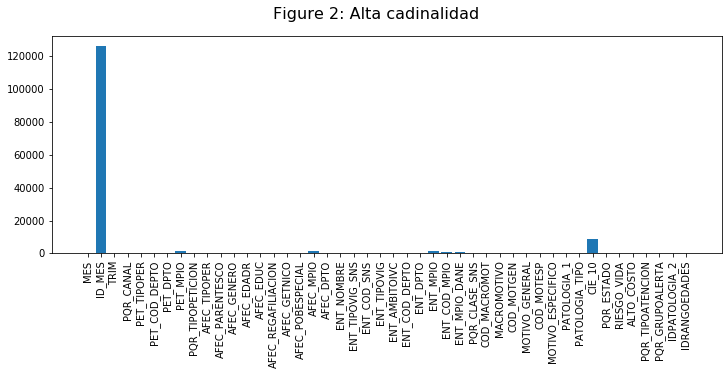

In [8]:
cardinality_columns = [df_reduced[col].unique().size for col in col_filtered]

fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.bar(col_filtered, cardinality_columns)
plt.xticks(rotation=90)
fig.suptitle('Figure 2: Alta cadinalidad', size = 16)

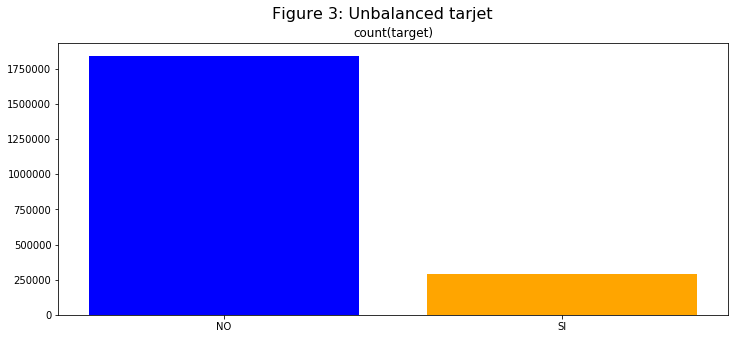

In [9]:
count_riesgo = df_reduced['RIESGO_VIDA'].value_counts()

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.bar(count_riesgo.keys()[0:2], count_riesgo.values[0:2], color = ['b', 'orange'])
axs.set_title("count(target)")
fig.suptitle('Figure 3: Unbalanced tarjet', size = 16);

In [10]:
df_reduced.shape

(2130783, 46)

#### Un análisis inicial de correlaciones sobre la columna objetivo RIESGO VIDA muestra una correlación muy pobre con otras características. Es muy probable que se deba a la escasez de datos (Figura 4).

/home/juanjosegdoj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


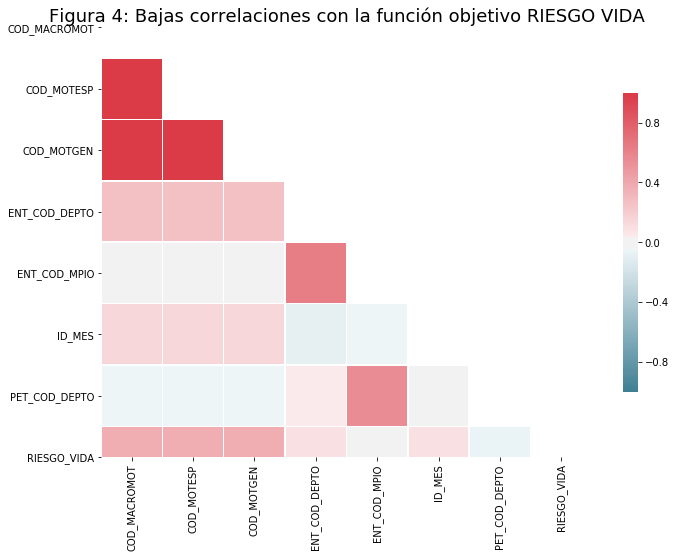

In [11]:
col_correl = ['COD_MACROMOT', 'COD_MOTESP', 'COD_MOTGEN', 'ENT_COD_DEPTO', 'ENT_COD_MPIO', 'ID_MES', 
              'PET_COD_DEPTO', 'RIESGO_VIDA']

# Debo convertir la variable categórica 'RIESGO_VIDA' a numérico para mostrar la correlación
df_corr = df_reduced[col_correl]
df_corr['RIESGO_VIDA'] = df_reduced['RIESGO_VIDA'].apply(lambda x: 1 if (x == 'NO') else 0)

corr =  df_corr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))
ax.set_title("Figura 4: Bajas correlaciones con la función objetivo RIESGO VIDA",  fontsize=18)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

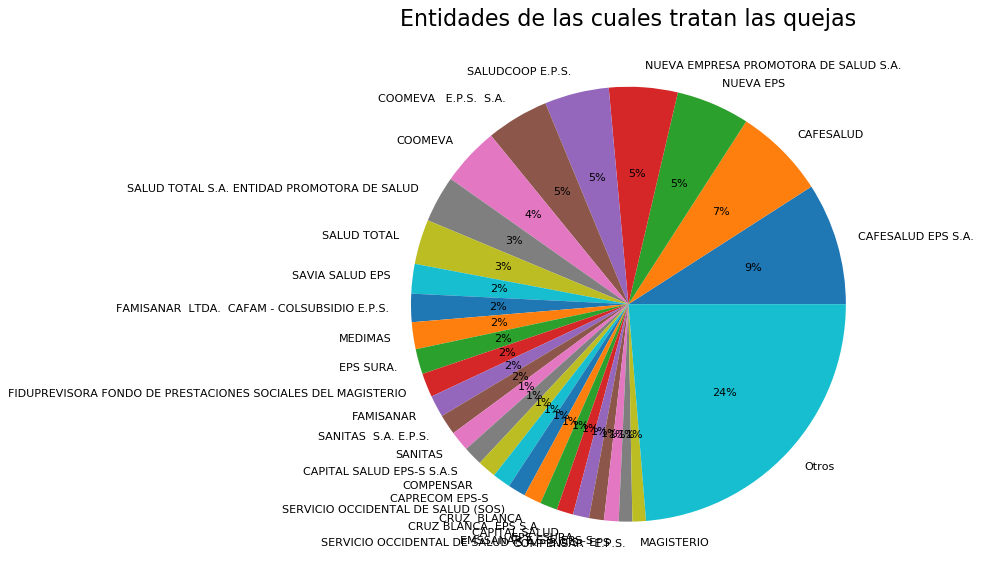

In [12]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

labels = df_reduced.ENT_NOMBRE.value_counts()[1:30].keys()
labels = np.append(labels, 'Otros')

values = df_reduced.ENT_NOMBRE.value_counts()[1:30].values
values = np.append(values, sum(df_reduced.ENT_NOMBRE.value_counts()[30:].values))

plt.pie(values, labels = labels, autopct='%1.0f%%');
plt.title('Entidades de las cuales tratan las quejas', fontsize=20);

### Motivos generales y específicos de qué trata la queja o solicitud de información

In [13]:
print(df_reduced.MOTIVO_GENERAL.unique().size)
df_reduced.MOTIVO_GENERAL.unique()

42


array(['RESTRICCION EN EL ACCESO POR FALTA DE OPORTUNIDAD PARA LA ATENCION ',
       'NEGACION DE LA PRESTACION DE SERVICIOS, INSUMOS O MEDICAMENTOS O ENTREGA DE MEDICAMENTOS',
       'RESTRICCION EN EL ACCESO POR DEMORAS EN LA AUTORIZACION',
       'NORMATIVIDAD DEL SGSSS',
       'RESTRICCION EN EL ACCESO POR NEGACION DE LA AUTORIZACION',
       'RESTRICCION EN EL ACCESO POR FALLAS EN LA AFILIACION',
       'INEFICACIA EN LA ATENCION ', 'RESTRICCION EN LA LIBRE ESCOGENCIA',
       'RESTRICCION EN EL ACCESO POR LOCALIZACION FISICA O  GEOGRAFICA',
       'LIMITACIONES EN LA INFORMACION',
       'RESTRICCION POR RAZONES ECONOMICA O DE CAPACIDAD DE PAGO.',
       'INSATISFACCION POR PROBLEMAS DE SALUD NO RESUELTOS. ',
       'LIMITACIONES EN LA INTEGRALIDAD, COORDINACION Y LONGITUDINALIDAD',
       'RECURSOS HUMANO INSUFICIENTE ',
       'RECURSOS FISICOS INSUFICIENTE O EN DEFICIENTES CONDICIONES',
       'LIMITACIONES TANGIBLES DEL SERVICIO',
       'PERCEPCION POR PARTE DEL USUSARIO DE

In [14]:
print(f"Cantidad de tipos de motvos específicos {df_reduced.MOTIVO_ESPECIFICO.unique().size}")

Cantidad de tipos de motvos específicos 334


#### PATOLOGÍA1 Y PATOLOGIA_TIPO son iguales en un 0.93%, ¿Vale la pena conservar las 2 variables?

In [15]:
(df_reduced.PATOLOGIA_1 == df_reduced.PATOLOGIA_TIPO).mean()

0.9261501523149002

In [16]:
df_reduced.CIE_10.value_counts()

0                                                                                       1849472
PROBLEMAS RELACIONADOS CON FACILIDADES DE ATENCIÓN MÉDICA U OTROS SERVICIOS DE SALUD       6133
HIPERTENSION ESENCIAL (PRIMARIA)                                                           5068
OTROS PROBLEMAS RELACIONADOS CON SERVICIOS MEDICOS Y DE SALUD                              5016
DIABETES MELLITUS INSULINODEPENDIENTE                                                      3862
                                                                                         ...   
TRASTORNO DEL SISTEMA NERVIOSO AUTONOMO, NO ESPECIFICADO                                      1
EXAMEN DE PESQUISA ESPECIAL PARA DIABETES MELLITUS                                            1
CUIDADOS POSTERIORES A LA CIRUGIA PLASTICA                                                    1
EFECTO DE LA PRESION DEL AIRE Y DEL AGUA, NO ESPECIFICADO                                     1
ARTRITIS JUVENIL EN LA COLITIS ULCERATIV

## 4.1 Datos perdidos
Resulta que la mayoría de los datos nulos que se presentan en esta base de datos, no se observan como NaN o None, sino que se esconde a través de un cero '0' o 0 .

### ¿Hasta que punto puedo decir que estoy trabajando con datos que tienen valor?

In [17]:
proporcion_nulos = df_original.eq('0').mean().values + df_original.eq(0).mean().values
columnas = df_original.columns

for i in range(len(columnas)):
    print(proporcion_nulos[i], ': ', columnas[i])

/home/juanjosegdoj/miniconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


0.0 :  MES
0.0 :  ID_MES
0.0 :  TRIM
0.0 :  PQR_CANAL
0.012195516859295387 :  PET_TIPOPER
0.014692251627688037 :  PET_COD_DEPTO
0.014692251627688037 :  PET_DPTO
0.014692251627688037 :  PET_MPIO
0.0 :  PQR_TIPOPETICION
0.3168464362631014 :  AFEC_TIPOPER
0.3193464562088209 :  AFEC_PARENTESCO
0.3253503524291305 :  AFEC_GENERO
0.3253634931384378 :  AFEC_EDADR
0.46205221273118846 :  AFEC_EDUC
0.3253794497140253 :  AFEC_REGAFILIACION
0.4649581867322951 :  AFEC_GETNICO
0.4581179782267833 :  AFEC_POBESPECIAL
0.34100750756881393 :  AFEC_MPIO
0.34100750756881393 :  AFEC_DPTO
0.3131599979913487 :  ENT_NOMBRE
0.19394185142269296 :  ENT_TIPOVIG_SNS
0.10908665969270451 :  ENT_COD_SNS
0.3306441810357976 :  ENT_TIPOVIG
0.5948170226625611 :  ENT_AMBITOIVC
0.20509455913624242 :  ENT_COD_DEPTO
0.20509455913624242 :  ENT_DPTO
0.2620431080968827 :  ENT_MPIO
0.18517277451528383 :  ENT_COD_MPIO
0.18517277451528383 :  ENT_MPIO_DANE
0.0 :  PQR_CLASE_SNS
0.0 :  COD_MACROMOT
0.0 :  MACROMOTIVO
0.0 :  COD_MOTGEN


In [18]:
most_missing_cols = set(df_reduced.columns[df_reduced.eq('0').mean() > 0.5])
most_missing_cols

{'CIE_10', 'PQR_GRUPOALERTA', 'PQR_TIPOATENCION'}

## ¿Es viable usar one hot encoding?
Como se observa, sólo la característica CIE_10 tiene más de 9000 características.

### ¿Qué efectos tiene usar un encoding normal? 
Porque ahora sé que tengo variables que realmente no tiene un significado especial, es decir, de alguna forma cuando hago el codificación le estoy dando más valor a los valores de la variable asignada el 2 que a la variable 1; y esto no tiene ningún significado estadístico entre ellas.

In [19]:
df_reduced['CIE_10'].unique().size

9028

In [20]:
df_reduced['CIE_10'][(df_reduced['CIE_10'] == 0) & (df_reduced['CIE_10'] == '0')] = np.NaN

/home/juanjosegdoj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
df_reduced[column_names].head()

,MES,ID_MES,TRIM,PQR_CANAL,PET_TIPOPER,PET_COD_DEPTO,PET_DPTO,PET_MPIO,PQR_TIPOPETICION,AFEC_TIPOPER,...,PATOLOGIA_1,PATOLOGIA_TIPO,CIE_10,PQR_ESTADO,RIESGO_VIDA,ALTO_COSTO,PQR_TIPOATENCION,PQR_GRUPOALERTA,IDPATOLOGIA_2,IDRANGOEDADES
0,1,14193.0,Trim I,PERSONALIZADO,Natural,5,ANTIOQUIA,BELLO,Reclamo,Natural,...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,0,Cerrado,NO,0.0,0,0,53.0,6
1,1,28651.0,Trim I,TELEFONICO,Natural,5,ANTIOQUIA,SAN PEDRO,Reclamo,Natural,...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,0,Cerrado,NO,0.0,0,0,53.0,7
2,1,15063.0,Trim I,TELEFONICO,Natural,5,ANTIOQUIA,MEDELLIN,Reclamo,Natural,...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,0,Cerrado,NO,0.0,0,0,53.0,7
3,1,21431.0,Trim I,TELEFONICO,Natural,5,ANTIOQUIA,MEDELLIN,Reclamo,Natural,...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,0,Cerrado,NO,0.0,0,0,53.0,9
4,1,30236.0,Trim I,TELEFONICO,Natural,5,ANTIOQUIA,SABANETA,Reclamo,Natural,...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,0,Cerrado,NO,0.0,0,0,53.0,7


## 5. Preprocesamiento de datos

### 5.1. Elimnando campos
Desechando variables que no tienen un uso estadísitico.

In [22]:
df_reduced['ALTO_COSTO'].value_counts()

0.0    2114238
Name: ALTO_COSTO, dtype: int64

In [23]:
df_reduced['PQR_ESTADO'].value_counts()

Cerrado                     1143650
0                            675059
Pendiente (Avance)           166226
Casos para instruccion        95868
Respuesta por la entidad      48176
REABIERTO                       954
Reabierto                       685
DIRECCIONAR                     145
Direccionar                      20
Name: PQR_ESTADO, dtype: int64

In [24]:
var_sin_valor_estadisitico = ['IDRANGOEDADES', 'ID_MES', 'PQR_GRUPOALERTA', 'ALTO_COSTO', 'PQR_ESTADO']
column_names = [col for col in column_names if col not in var_sin_valor_estadisitico]

- la función "PQR ESTADO" tiene un valor estadístico significativo que puede sesgar el modelo: una vez que un derecho de solicitud ingresa al sistema, pasa por una serie de estados antes de que se cierre el caso (ese estado se almacena en " PQR ESTADO "). Históricamente, los pacientes con riesgo de vida pueden tener una tendencia a tener un estado cerrado, ya que pueden tener prioridad sobre otros casos, por lo que incluir "PQR ESTADO" hará que el modelo haga predicciones sobre una característica que no estará disponible al introducir un nuevo derecho de solicitud (cuando un nuevo derecho de solicitud ingresa al sistema tendrá un estado predeterminado que es muy poco probable que tenga el estado final del conjunto de datos original).
- PQR_GRUPOALERTA es utilizado para la parametrización de la Base de Datos, pero no es utilizada para fines estadísticos.
- ENTIDAD_FUNC Campo en Blanco, utilizado para parametrización de la base de datos, pero no es utilizada para fines estadísticos

### Figura 5: Algunas características adquieren significado estadístico

### 5.3 Características redundantes
Estas características representan los mismos datos (100% de correlación), con lo cual, se debe desechar alguna de las dos.

- COD MACROMOT es el código para MACROMOTIVO
- COD MOTGEN es el código para MOTIVO GENERAL
- COD MOTESP es el código para MOTIVO ESPECIFICO
- ENT COD DEPTO es el código para ENT DPTO
- ENT COD MPIO es el código para ENT MPIO
- PET COD DEPTO es el código para PET DPTO

In [25]:
var_redundante = ['COD_MACROMOT', 'COD_MOTGEN', 'COD_MOTESP', 
                           'ENT_COD_DEPTO', 'ENT_COD_MPIO', 'PET_COD_DEPTO', 'IDPATOLOGIA_2']
column_names = [col for col in column_names if col not in var_redundante]

### 7.4. Más Limpieza

In [26]:
condicion_1 = df_reduced['PET_DPTO'] == 'ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA'
condicion_2 = df_reduced['PET_DPTO'] == 'SAN ANDRÉS'
condicion_3 = df_reduced['PET_DPTO'] == 'BOGOTA D.C'

df_reduced.loc[condicion_1, 'PET_DPTO'] = "SAN ANDRES"
df_reduced.loc[condicion_2, 'PET_DPTO'] = "SAN ANDRES"
df_reduced.loc[condicion_3, 'PET_DPTO'] = "BOGOTA D.C."

In [27]:
df_reduced['AFEC_DPTO'].unique()

array(['ANTIOQUIA', '0', 'BOGOTA D.C', 'ATLANTICO', 'CAUCA', 'ARAUCA',
       'CALDAS', 'VALLE DEL CAUCA', 'HUILA', 'CESAR', 'CUNDINAMARCA',
       'SANTANDER', 'RISARALDA', 'META', 'BOLIVAR', 'BOYACA', 'CAQUETA',
       'CASANARE', 'CORDOBA', 'GUAVIARE', 'LA GUAJIRA', 'MAGDALENA',
       'NARIÑO', 'NORTE DE SANTANDER', 'PUTUMAYO', 'QUINDIO',
       'ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA',
       'TOLIMA', 'SUCRE', 'VICHADA', 'CHOCO', 'AMAZONAS', 'GUAINIA',
       'VAUPES', 'VALLE', 'BOGOTA D.C.', 'SAN ANDRES', 'SAN ANDRÉS'],
      dtype=object)

In [28]:
condicion_1 = df_reduced['AFEC_DPTO'] == 'ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA'
condicion_2 = df_reduced['AFEC_DPTO'] == 'SAN ANDRÉS'
condicion_3 = df_reduced['AFEC_DPTO'] == 'BOGOTA D.C'

df_reduced.loc[condicion_1, 'AFEC_DPTO'] = "SAN ANDRES"
df_reduced.loc[condicion_2, 'AFEC_DPTO'] = "SAN ANDRES"
df_reduced.loc[condicion_3, 'AFEC_DPTO'] = "BOGOTA D.C."

#### Después de este proceso de limpieza inicial, algunas características comienzan a mostrar más significado estadístico que el conjunto de datos anterior (Figura 7).

In [29]:
df_reduced.loc[df_reduced['ENT_TIPOVIG_SNS'].isna(), 'ENT_TIPOVIG_SNS'] = np.NaN

In [30]:
#df_reduced = df_reduced.dropna(how='any',axis=0)

In [31]:
for col in column_names:
    df_reduced[col][df_reduced[col] == '0'] = np.NaN
    df_reduced[col][df_reduced[col] == 0] = np.NaN

/home/juanjosegdoj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/juanjosegdoj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
df_reduced[column_names].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2130783 entries, 0 to 655324
Data columns (total 34 columns):
MES                   int64
TRIM                  object
PQR_CANAL             object
PET_TIPOPER           object
PET_DPTO              object
PET_MPIO              object
PQR_TIPOPETICION      object
AFEC_TIPOPER          object
AFEC_PARENTESCO       object
AFEC_GENERO           object
AFEC_EDADR            object
AFEC_EDUC             object
AFEC_REGAFILIACION    object
AFEC_GETNICO          object
AFEC_POBESPECIAL      object
AFEC_MPIO             object
AFEC_DPTO             object
ENT_NOMBRE            object
ENT_TIPOVIG_SNS       object
ENT_COD_SNS           object
ENT_TIPOVIG           object
ENT_AMBITOIVC         object
ENT_DPTO              object
ENT_MPIO              object
ENT_MPIO_DANE         object
PQR_CLASE_SNS         object
MACROMOTIVO           object
MOTIVO_GENERAL        object
MOTIVO_ESPECIFICO     object
PATOLOGIA_1           object
PATOLOGIA_TIPO     

Se elimnan todos los registros que tengan más de 3 valores nulos

In [33]:
print(df_reduced.shape)
df_reduced = df_reduced[df_reduced[column_names].isnull().sum(axis=1) <= 3]
print(df_reduced.shape)

(2130783, 46)
(1102799, 46)


Finalmente, Al resto de valores nulos los lleno con la moda, debido a que los valores son categóricos.

In [34]:
for col in column_names:
    df_reduced[col].fillna(df_reduced[col].mode()[0], inplace = True)

/home/juanjosegdoj/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [35]:
df_reduced[column_names].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1102799 entries, 0 to 655324
Data columns (total 34 columns):
MES                   1102799 non-null int64
TRIM                  1102799 non-null object
PQR_CANAL             1102799 non-null object
PET_TIPOPER           1102799 non-null object
PET_DPTO              1102799 non-null object
PET_MPIO              1102799 non-null object
PQR_TIPOPETICION      1102799 non-null object
AFEC_TIPOPER          1102799 non-null object
AFEC_PARENTESCO       1102799 non-null object
AFEC_GENERO           1102799 non-null object
AFEC_EDADR            1102799 non-null object
AFEC_EDUC             1102799 non-null object
AFEC_REGAFILIACION    1102799 non-null object
AFEC_GETNICO          1102799 non-null object
AFEC_POBESPECIAL      1102799 non-null object
AFEC_MPIO             1102799 non-null object
AFEC_DPTO             1102799 non-null object
ENT_NOMBRE            1102799 non-null object
ENT_TIPOVIG_SNS       1102799 non-null object
ENT_COD_SNS    

In [36]:
# Guardando dataset antes de aplicar el encoding
df_reduced[column_names].to_csv (r'datasets/cleaned_dataset_sin_encoding.csv', index = None, header=True)

### Figura 8. Encoding
¿Mean Encoding? https://towardsdatascience.com/why-you-should-try-mean-encoding-17057262cd0

In [37]:
cols2enc = df_reduced[column_names].select_dtypes(include=object).columns
labelencoder = LabelEncoder()

col_variables = []
for coln in cols2enc:
    form_name = coln+"_enc"
    df_reduced[form_name] = labelencoder.fit_transform(np.array(
                                df_reduced[coln].astype(str).values).reshape(-1,1))
    column_names.append(form_name)
    column_names.remove(coln);
    if coln != 'RIESGO_VIDA':
        col_variables.append(form_name)

/home/juanjosegdoj/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/juanjosegdoj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
df_reduced[col_variables].head()

,TRIM_enc,PQR_CANAL_enc,PET_TIPOPER_enc,PET_DPTO_enc,PET_MPIO_enc,PQR_TIPOPETICION_enc,AFEC_TIPOPER_enc,AFEC_PARENTESCO_enc,AFEC_GENERO_enc,AFEC_EDADR_enc,...,ENT_MPIO_enc,ENT_MPIO_DANE_enc,PQR_CLASE_SNS_enc,MACROMOTIVO_enc,MOTIVO_GENERAL_enc,MOTIVO_ESPECIFICO_enc,PATOLOGIA_1_enc,PATOLOGIA_TIPO_enc,CIE_10_enc,PQR_TIPOATENCION_enc
0,0,6,1,1,109,3,1,10,0,4,...,668,514,0,6,33,101,16,392,6513,2
2,0,8,1,1,639,3,1,10,1,5,...,668,514,0,6,33,101,16,392,6513,2
7,0,10,1,1,639,3,1,11,1,8,...,668,514,0,6,33,101,16,392,6513,2
11,1,8,1,1,639,3,1,10,1,8,...,668,514,0,6,33,101,16,392,6513,2
14,1,10,1,1,639,3,1,10,1,3,...,668,514,0,6,33,101,16,392,6513,2


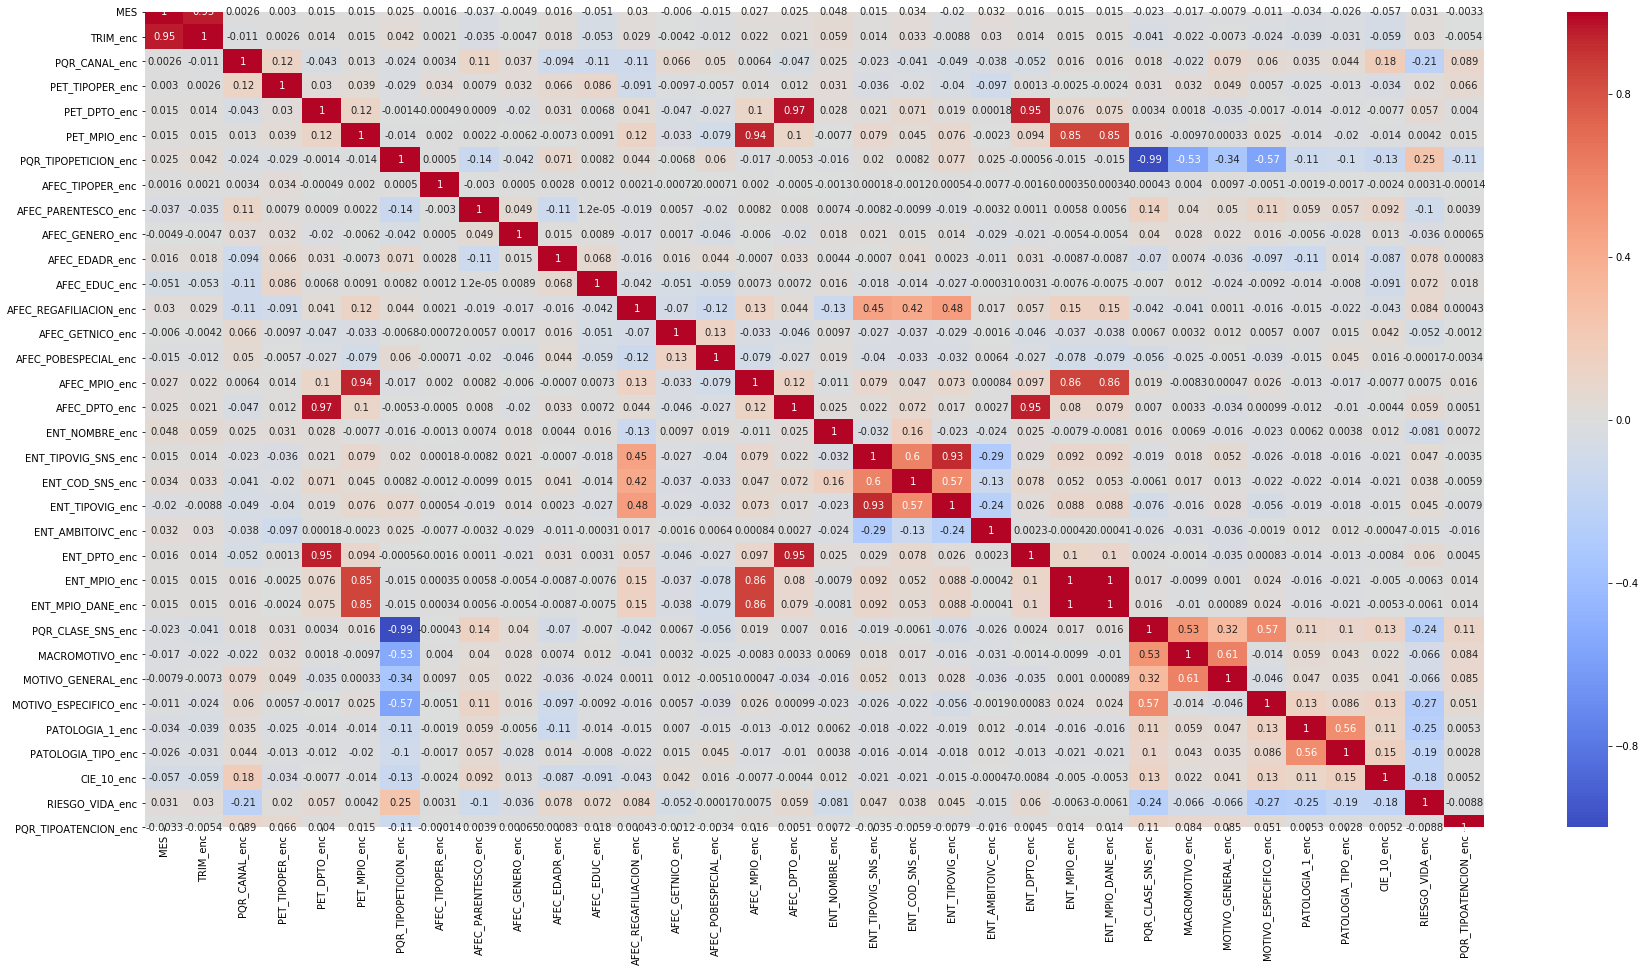

In [39]:
plt.figure(figsize=(30,15))
sns.heatmap(df_reduced[column_names].corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

#### ¿Qué información puedo sacar de la anterior matriz de correlacion?

## 3. Metrics

$F_β = (1 + β^2) × \dfrac{precision × recall}{β^2 × precision) + sensibilidad} , β = 2$ , En lugar de usar precision y recall individualmente buscando un clasificador con el mejor rendimiento, se utiliza $F_β$.

https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

## Benchmark
Se utilizará un modelo de regresión logística como base para comparar con el modelo final para demuestrar la necesidad de implementar una solución no lineal al problema.

In [40]:
etiquetas = df_reduced['RIESGO_VIDA_enc']
caracteristicas = df_reduced[col_variables]

df_reduced.head()

,MES,ID_MES,TRIM,PQR_CANAL,PET_TIPOPER,PET_COD_DEPTO,PET_DPTO,PET_MPIO,PQR_TIPOPETICION,AFEC_TIPOPER,...,ENT_MPIO_DANE_enc,PQR_CLASE_SNS_enc,MACROMOTIVO_enc,MOTIVO_GENERAL_enc,MOTIVO_ESPECIFICO_enc,PATOLOGIA_1_enc,PATOLOGIA_TIPO_enc,CIE_10_enc,RIESGO_VIDA_enc,PQR_TIPOATENCION_enc
0,1,14193.0,Trim I,PERSONALIZADO,Natural,5,ANTIOQUIA,BELLO,Reclamo,Natural,...,514,0,6,33,101,16,392,6513,0,2
2,1,15063.0,Trim I,TELEFONICO,Natural,5,ANTIOQUIA,MEDELLIN,Reclamo,Natural,...,514,0,6,33,101,16,392,6513,0,2
7,1,17011.0,Trim I,WEB,Natural,5,ANTIOQUIA,MEDELLIN,Reclamo,Natural,...,514,0,6,33,101,16,392,6513,0,2
11,1,5570.0,Trim II,TELEFONICO,Natural,5,ANTIOQUIA,MEDELLIN,Reclamo,Natural,...,514,0,6,33,101,16,392,6513,0,2
14,1,77022.0,Trim II,WEB,Natural,5,ANTIOQUIA,MEDELLIN,Reclamo,Natural,...,514,0,6,33,101,16,392,6513,0,2


In [41]:
X_train, X_test, y_train, y_test = train_test_split(caracteristicas, etiquetas, test_size = 0.20, random_state = 10)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score

clf = LogisticRegression(random_state = 300)
clf = clf.fit(X_train, y_train)
predictions_test = clf.predict(X_test)

f_test =  fbeta_score(y_test, predictions_testtions_test, 2)
print(f_test)

/home/juanjosegdoj/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.2836200245086915


In [43]:
# Creando una copia para correr los modelos en otro notebook

col_variables.append('RIESGO_VIDA_enc')
df_reduced[col_variables].to_csv (r'datasets/cleaned_dataset.csv', index = None, header=True)

## 5. Algoritmos y técnicas

Dada la baja correlación con la variable objetivo, y el hecho de que existen muchas características, el modelo requería confiar en una combinación de boosting learners y stacking methods para llevar el puntaje lo más alto posible. El muestreo por encima y por debajo también se tendrá en cuenta.

Para ayudar a aumentar el puntaje, se seleccionaron los alumnos del conjunto RandomForestClassifier y AdaBoostClassifier debido a la velocidad relativamente baja para el entrenamiento con los parámetros predeterminados y la búsqueda de cuadrícula.

**RandomForestClassifier** ayuda a minimizar el problema de sobreajuste con árboles de decisión y funciona bien con grandes conjuntos de datos (el conjunto de datos para este proyecto es mayor a un millón de registros).

**AdaBoostClassifier** utiliza pocos parámetros, por lo que puede ser más fácil de configurar y está diseñado para aumentar el rendimiento de los árboles de decisión en las clasificaciones binarias, lo que lo hace un buen ajuste para este proyecto.

**Gaussian Naive Bayes** se consideró porque se trata de valores reales y el conjunto de datos se compone de valores reales después del preprocesamiento.

Los datos se dividieron en datos de entrenamiento, test y validación. El proceso de entrenamiento y ajuste se realizó sobre el conjunto de datos de entrenamiento y prueba y luego los modelos donde se expusieron a datos invisibles con el conjunto de datos de validación.

## Ensamble learners
**Bagging:** Learners homogeneos y aprenden de forma independiente.

**Boosting:** Learners homogeneos y aprenden secuencialmente de una forma adaptativa.

**Stacking:** Learners heterogeneos y aprenden de forma independiente.

https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de

## Observaciones
- La regla dice que lo primero que se debe hacer, es separar los datos de train y test, sin embargo, yo sé que la limpieza de este notebook no tendrá ningún sesgo.